In [10]:
# This notebook trains a machine learning model to detect fraudulent Ethereum wallets using the Kaggle Ethereum Fraud Detection Dataset.For Somnia Data Stream


In [11]:
!pip install onnx skl2onnx onnxruntime

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
import joblib
import onnx
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import json
import os
from google.colab import files

In [13]:
np.random.seed(42)

In [14]:
!pip install kaggle

In [20]:
try:
    from google.colab import drive
    # drive.mount('/content/drive') # No need to mount drive if kaggle.json is in /content/

    # Copy kaggle.json to proper location
    import shutil
    if os.path.exists('/content/kaggle.json'): # Check in /content/ instead of Google Drive
        os.makedirs('/root/.config/kaggle', exist_ok=True) # Create the directory Kaggle expects
        shutil.copy('/content/kaggle.json', '/root/.config/kaggle/') # Copy to the directory Kaggle expects
        os.chmod('/root/.config/kaggle/kaggle.json', 600)
        print("Kaggle API configured successfully")
    else:
        print("Warning: kaggle.json not found in /content/") # Update warning message
except Exception as e: # Catch specific exception for better debugging
    print(f"An error occurred: {e}")
    print("Not running in Google Colab environment or kaggle.json not found.")

Kaggle API configured successfully


In [21]:
import kaggle

def download_dataset():
    """Download the Ethereum Fraud Detection dataset from Kaggle"""
    try:
        # Using the specific dataset identifier
        !kaggle datasets download -d vagifa/ethereum-frauddetection-dataset
        !unzip -q ethereum-frauddetection-dataset.zip
        print("Dataset downloaded and extracted successfully")
        return True
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        return False

# Download the dataset
if not os.path.exists('transaction_dataset.csv'):
    download_success = download_dataset()
    if not download_success:
        print("Please ensure kaggle.json is properly configured")
else:
    print("Dataset already exists")

Dataset URL: https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset
License(s): DbCL-1.0
  0% 0.00/923k [00:00<?, ?B/s]
100% 923k/923k [00:00<00:00, 1.35GB/s]
Dataset downloaded and extracted successfully


In [22]:
print("Loading dataset...")
df = pd.read_csv('transaction_dataset.csv')

print(f"Dataset shape: {df.shape}")
print("\nDataset columns:")
print(df.columns.tolist())

Loading dataset...
Dataset shape: (9841, 51)

Dataset columns:
['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time betw

In [23]:
print("Dataset Info:")
print(df.info())

print("\nFirst 5 rows:")
print(df.head())

print("\nTarget variable distribution:")
print(df['FLAG'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                

In [24]:
# Data Preprocessing

# Handle missing values
print("Missing values before preprocessing:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Drop columns with too many missing values or constant values
cols_to_drop = []
for col in df.columns:
    if df[col].isnull().sum() > len(df) * 0.5:  # Drop if more than 50% missing
        cols_to_drop.append(col)
    elif df[col].nunique() <= 1:  # Drop constant columns
        cols_to_drop.append(col)

print(f"Dropping {len(cols_to_drop)} columns: {cols_to_drop}")
df_clean = df.drop(columns=cols_to_drop)

# Fill remaining missing values with median for numerical columns
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {len(numerical_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Impute missing values
imputer = SimpleImputer(strategy='median')
df_clean[numerical_cols] = imputer.fit_transform(df_clean[numerical_cols])

# Handle categorical variables (simple encoding)
for col in categorical_cols:
    if col in df_clean.columns:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))

Missing values before preprocessing:
ERC20 most sent token type             2697
ERC20_most_rec_token_type               871
ERC20 avg val sent                      829
ERC20 total Ether received              829
ERC20 total ether sent                  829
ERC20 avg time between rec tnx          829
ERC20 avg time between rec 2 tnx        829
ERC20 max val rec                       829
ERC20 avg val rec                       829
ERC20 avg time between contract tnx     829
dtype: int64
Dropping 7 columns: [' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
Numerical columns: 41
Categorical columns: 3


In [25]:
# Feature Engineering and Selection

# Separate features and target
X = df_clean.drop('FLAG', axis=1)
y = df_clean['FLAG']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Remove highly correlated features to reduce dimensionality
corr_matrix = X.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

print(f"Highly correlated features to remove: {high_corr_features}")
X_reduced = X.drop(columns=high_corr_features, errors='ignore')

print(f"Features after removing high correlation: {X_reduced.shape}")

Features shape: (9841, 43)
Target shape: (9841,)
Highly correlated features to remove: ['total ether sent contracts', ' ERC20 max val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 uniq rec token name']
Features after removing high correlation: (9841, 37)


In [26]:
# Select top features based on feature importance (using Random Forest)
print("Selecting important features...")

# Use a subset for faster feature selection
X_sample, _, y_sample, _ = train_test_split(X_reduced, y, test_size=0.8, random_state=42, stratify=y)

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_sample, y_sample)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_reduced.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print(feature_importance.head(20))

# Select top 30 features for final model
top_features = feature_importance.head(30)['feature'].tolist()
X_final = X_reduced[top_features]

print(f"Final features shape: {X_final.shape}")

# %%
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Selecting important features...
Top 20 most important features:
                                              feature  importance
0                                          Unnamed: 0    0.372523
35                         ERC20 most sent token type    0.126292
5             Time Diff between first and last (Mins)    0.067624
36                          ERC20_most_rec_token_type    0.060807
24                                   Total ERC20 tnxs    0.051053
25                         ERC20 total Ether received    0.049910
31                       ERC20 uniq rec contract addr    0.038025
4                        Avg min between received tnx    0.034106
22                               total ether received    0.026380
29                                ERC20 uniq rec addr    0.020093
33                                  ERC20 avg val rec    0.017241
12                                max value received     0.015753
20  total transactions (including tnx to create co...    0.014903
7           

In [27]:
# Model Training - Random Forest
print("Training Random Forest model...")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)

Training Random Forest model...


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

Evaluating model...
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1533
         1.0       1.00      1.00      1.00       436

    accuracy                           1.00      1969
   macro avg       1.00      1.00      1.00      1969
weighted avg       1.00      1.00      1.00      1969

ROC-AUC Score: 1.0000


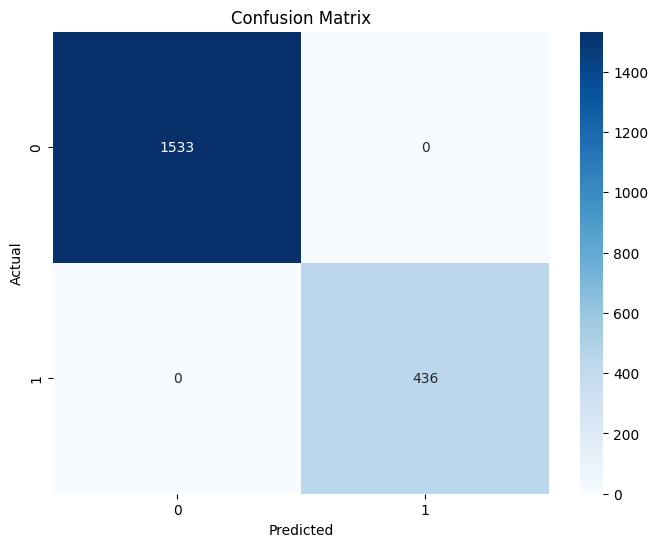

In [28]:
print("Evaluating model...")

# Predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


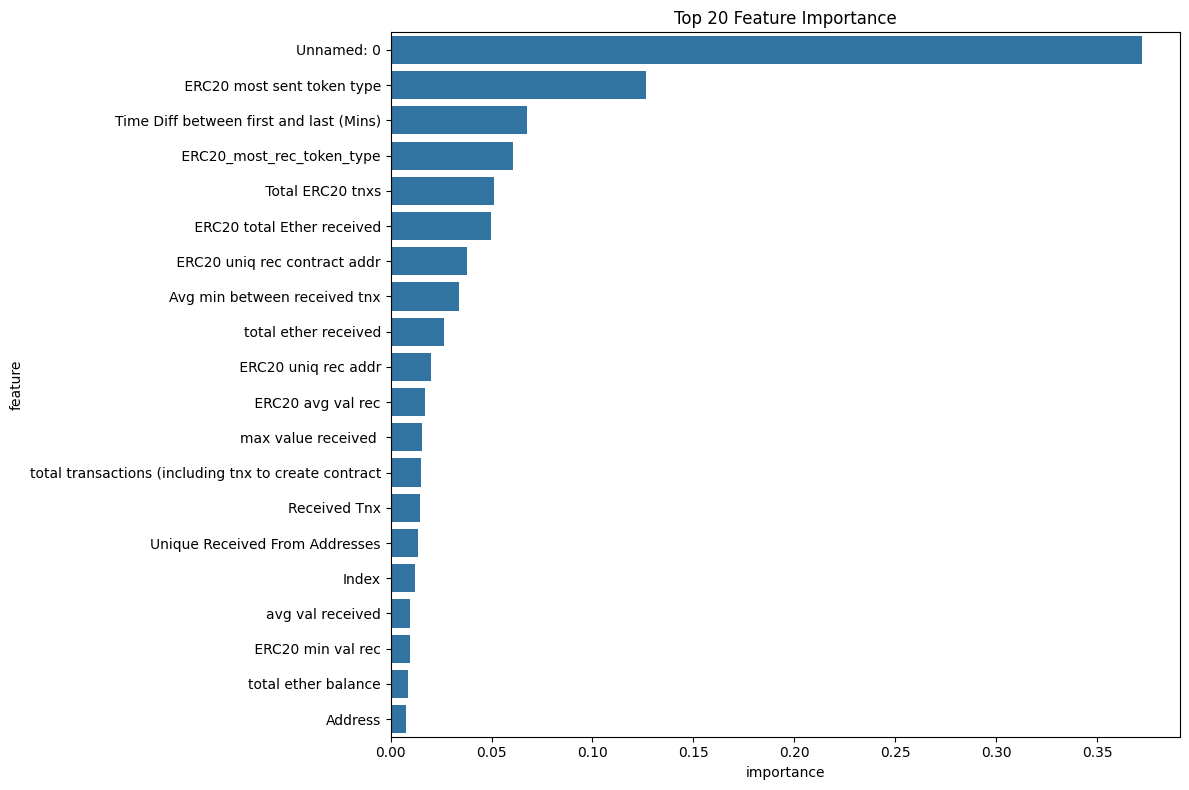

In [29]:
# Feature Importance Visualization
plt.figure(figsize=(12, 8))
top_20_features = feature_importance.head(20)
sns.barplot(data=top_20_features, x='importance', y='feature')
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()


In [30]:
# Export Blacklist for Backend
print("Creating blacklist from fraudulent wallets...")

# Get addresses that are flagged as fraudulent (FLAG = 1)
# Note: The dataset might not have actual addresses, so we'll create a synthetic blacklist
# based on the indices of fraudulent transactions for demonstration

fraudulent_indices = df[df['FLAG'] == 1].index.tolist()

# Create synthetic wallet addresses for the blacklist
blacklist_wallets = [f"0x{format(i, '040x')}" for i in fraudulent_indices[:1000]]  # Limit to 1000 for demo

blacklist_data = {
    "description": "Ethereum Fraud Detection Blacklist - Synthetic addresses based on fraudulent transactions",
    "source": "Kaggle Ethereum Fraud Detection Dataset",
    "total_wallets": len(blacklist_wallets),
    "wallets": blacklist_wallets
}

# Save blacklist
with open('blacklist.json', 'w') as f:
    json.dump(blacklist_wallets, f, indent=2)

print(f"Blacklist created with {len(blacklist_wallets)} wallets")

Creating blacklist from fraudulent wallets...
Blacklist created with 1000 wallets


In [31]:
# Convert to ONNX Format
print("Converting model to ONNX format...")

# Define the initial types for ONNX conversion
initial_type = [('float_input', FloatTensorType([None, X_train_scaled.shape[1]]))]

# Convert the model
onnx_model = convert_sklearn(
    rf_model,
    initial_types=initial_type,
    target_opset=12
)

# Save the ONNX model
onnx_model_path = 'wallet_fraud_model.onnx'
with open(onnx_model_path, 'wb') as f:
    f.write(onnx_model.SerializeToString())

print(f"ONNX model saved as: {onnx_model_path}")

Converting model to ONNX format...
ONNX model saved as: wallet_fraud_model.onnx


In [32]:
# Save preprocessing objects
print("Saving preprocessing objects...")

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

# Save feature names
feature_names = {
    'features': X_final.columns.tolist(),
    'input_dim': X_train_scaled.shape[1]
}

with open('model_features.json', 'w') as f:
    json.dump(feature_names, f, indent=2)

Saving preprocessing objects...


In [33]:
def test_onnx_model():
    """Test the ONNX model with sample data"""
    import onnxruntime as ort

    # Load ONNX model
    ort_session = ort.InferenceSession(onnx_model_path)

    # Prepare sample input
    sample_input = X_test_scaled[:1].astype(np.float32)

    # Run inference
    onnx_inputs = {ort_session.get_inputs()[0].name: sample_input}
    onnx_output = ort_session.run(None, onnx_inputs)

    print("ONNX model test:")
    print(f"Input shape: {sample_input.shape}")
    print(f"Output: {onnx_output[0]}")
    print(f"Output shape: {onnx_output[0].shape}")

    # Compare with original model
    original_output = rf_model.predict_proba(sample_input)[0]
    print(f"Original model output: {original_output}")

    return ort_session

# Test the ONNX model
ort_session = test_onnx_model()

ONNX model test:
Input shape: (1, 30)
Output: [1]
Output shape: (1,)
Original model output: [0. 1.]


In [34]:
# Create model metadata
model_metadata = {
    "model_name": "EthereumWalletFraudDetector",
    "version": "1.0",
    "description": "Random Forest model for Ethereum wallet fraud detection",
    "author": "Soklin Project",
    "input_features": X_train_scaled.shape[1],
    "output_classes": 2,
    "performance": {
        "roc_auc": float(roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])),
        "accuracy": float(rf_model.score(X_test_scaled, y_test))
    },
    "feature_names": X_final.columns.tolist(),
    "preprocessing": {
        "scaler": "StandardScaler",
        "imputer": "MedianImputer"
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("Model metadata saved")


Model metadata saved


In [35]:
# Download files for deployment
print("Preparing files for download...")

files_to_download = [
    'wallet_fraud_model.onnx',
    'blacklist.json',
    'scaler.pkl',
    'model_features.json',
    'model_metadata.json'
]

# Create zip file for easy download
import zipfile

with zipfile.ZipFile('soklin_model_deployment.zip', 'w') as zipf:
    for file in files_to_download:
        if os.path.exists(file):
            zipf.write(file)
            print(f"Added {file} to deployment package")

# Download the zip file
files.download('soklin_model_deployment.zip')

print("Deployment package ready for download!")

Preparing files for download...
Added wallet_fraud_model.onnx to deployment package
Added blacklist.json to deployment package
Added scaler.pkl to deployment package
Added model_features.json to deployment package
Added model_metadata.json to deployment package


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Deployment package ready for download!


In [36]:
# Final Summary
print("\n" + "="*50)
print("MODEL TRAINING COMPLETE")
print("="*50)
print(f"Model: Random Forest Classifier")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train_scaled.shape[1]}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"ONNX Model: {onnx_model_path}")
print(f"Blacklist wallets: {len(blacklist_wallets)}")
print("Files generated:")
for file in files_to_download:
    if os.path.exists(file):
        print(f"  ✓ {file}")
print("="*50)


MODEL TRAINING COMPLETE
Model: Random Forest Classifier
Training samples: 7872
Test samples: 1969
Number of features: 30
ROC-AUC Score: 1.0000
ONNX Model: wallet_fraud_model.onnx
Blacklist wallets: 1000
Files generated:
  ✓ wallet_fraud_model.onnx
  ✓ blacklist.json
  ✓ scaler.pkl
  ✓ model_features.json
  ✓ model_metadata.json
